## Miquel Monge Dalmau
---


# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). 

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch Version:  1.11.0+cu113
Using device: cuda:0


### Download the Shakespeare dataset

In [ ]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2022-05-19 08:01:40--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2022-05-19 08:01:40 (57.3 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values. 

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [ ]:
class ShakespeareDataset():
    def __init__(self, sequence_length,):
        self.sequence_length = sequence_length
        # The whole sequence of characters in the text file (including chracters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indexes as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indexes as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indexes = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open('shakespeare.txt') as fp:
          text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indexes)-self.sequence_length,self.sequence_length):
            x.append(np.array(self.chars_indexes[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indexes[index+1:index+self.sequence_length+1]))
        
        return  np.array(x), np.array(y)

Now we can use the [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) classes to create the PyTorch dataloader. Notice that the `TensorDataset` class allows us to easily create a PyTorch `Dataset` from numpy arrays `(inputs, labels)`.

In [ ]:
# Create the dataset
sequence_length = 100
dataset = ShakespeareDataset(sequence_length)

print(f'We have {dataset.x.shape[0]} input sequence samples of length {dataset.x.shape[1]} \
and {dataset.y.shape[0]} label sequences of length {dataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_data = TensorDataset(torch.from_numpy(dataset.x), torch.from_numpy(dataset.y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

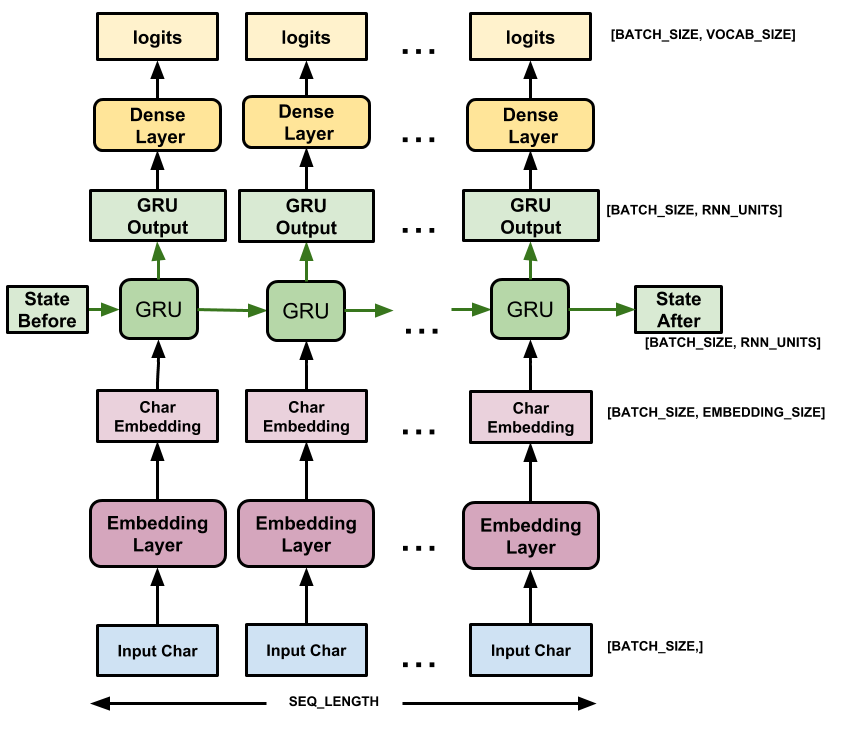

Image source: http://www.tensorflow.org

**EXERCISE 1** Complete the code of the `Model` class:

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim)).to(device)
        return hidden



Now we can instantiate the model as follows:

In [ ]:
input_dim = len(dataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(dataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

**EXERCISE 2** which loss function do you think we shall use to train our model?

In [ ]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        state = model.init_hidden(batch_size)

        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)

            state = state.detach()

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
              losses.append(loss.detach().cpu().numpy())
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

{'epoch': 0, 'batch': 0, 'loss': 4.175439357757568}
{'epoch': 0, 'batch': 30, 'loss': 2.2867114543914795}
{'epoch': 0, 'batch': 60, 'loss': 1.9806715250015259}
{'epoch': 0, 'batch': 90, 'loss': 1.8231812715530396}
{'epoch': 0, 'batch': 120, 'loss': 1.6907559633255005}
{'epoch': 0, 'batch': 150, 'loss': 1.6202044486999512}
{'epoch': 1, 'batch': 0, 'loss': 1.5417284965515137}
{'epoch': 1, 'batch': 30, 'loss': 1.5057454109191895}
{'epoch': 1, 'batch': 60, 'loss': 1.5266615152359009}
{'epoch': 1, 'batch': 90, 'loss': 1.4766589403152466}
{'epoch': 1, 'batch': 120, 'loss': 1.4208849668502808}
{'epoch': 1, 'batch': 150, 'loss': 1.4527883529663086}
{'epoch': 2, 'batch': 0, 'loss': 1.371360182762146}
{'epoch': 2, 'batch': 30, 'loss': 1.4333128929138184}
{'epoch': 2, 'batch': 60, 'loss': 1.3848682641983032}
{'epoch': 2, 'batch': 90, 'loss': 1.4054200649261475}
{'epoch': 2, 'batch': 120, 'loss': 1.383611798286438}
{'epoch': 2, 'batch': 150, 'loss': 1.3658093214035034}
{'epoch': 3, 'batch': 0, 'lo

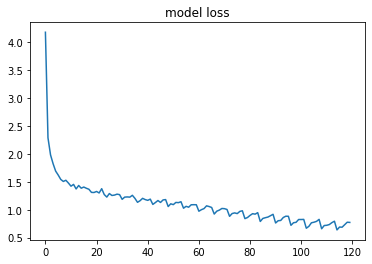

In [ ]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [ ]:
with torch.no_grad():
  input_str = 'ROMEO:'

  state = model.init_hidden(batch_size=1)
  input = torch.tensor([[dataset.char_to_index[char] for char in input_str]]).to(device)
  output, state = model(input, state)

  logits = output[0].cpu().numpy()
  predicted_indexes = np.argmax(logits, axis=1)
  
  predicted_str = ''.join([dataset.index_to_char[idx] for idx in predicted_indexes])

  print(f'Input shape: {input.size()}')
  print(f'Output shape: {input.size()}')
  print(f'Input string: {input_str}')
  print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: DKEO:



## Generate new text

In [ ]:
with torch.no_grad():
  input_str = 'ROMEO:'

  state = model.init_hidden(batch_size=1)
  input = torch.tensor([[dataset.char_to_index[char] for char in input_str]]).to(device)
  output, state = model(input, state)

  logits = output[0].cpu().numpy()
  predicted_indexes = np.argmax(logits, axis=1)
  
  predicted_str = ''.join([dataset.index_to_char[idx] for idx in predicted_indexes])

  print(f'Input shape: {input.size()}')
  print(f'Output shape: {input.size()}')
  print(f'Input string: {input_str}')
  print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: DKEO:



In [ ]:
def predict(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1)

    # we start by feeding all the input characters to our model
    x = torch.tensor([[dataset.char_to_index[char] for char in chars[0:]]])
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)


    return chars

predicted = predict(dataset,model,'ROMEO:')
print(''.join(predicted))

ROMEO:
She stands where.

GONZALO:
But not a ser, thou know'st, swallows and Rosaline:
Bag for this gentleman, t which pleaseth not to evil and servant; but one word.

PRINCE:
That this be seen and catching show.
Did ever dragon me whose dealines have more better than he,
So many an enemy in his honour,
I thought they here stand upon my hands,
Injury to Richmond, with two dread heir nor goods,
But that we lose the sense is but ne'er so lie;
If not yet far on earth, I never die,
Whose top is thirty.

CAPULET:
Nay, 'tis not moonly sure deservedly news,
Which should the leanness that doth make me faint
The other with her set, 'tis fit to do it in this ear.

KING RICHARD III:
A heavy curdience, heir to grace, O voil,
Have we my brother end, and now I will not but
Our Rome was laughing winds.

KING EDWARD IV:
But if you give me leave, grown born.

JULIET:
I will be lackey.

FRIAR LAURENCE:
Benvol, is gone?
I'll not put to the butcher's senate,
And neither play am bold between us; my request

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.


# HOMEWORK

A) Build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). Train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare their loss curves. You can optionally try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc. 

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0., rnn_cell='RNN'):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn_cell = rnn_cell
        if self.rnn_cell == "GRU":
            print("Using GRU")
            self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        elif self.rnn_cell == "LSTM":
            print("Using LSTM")
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first=True)
        else:
            print("Using default Simple RNN cells")
            self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x, h, c = None):
        emb = self.embedding(x)
        # in LSTM we habe a cell state and a hidden state
        if self.rnn_cell == "LSTM": 
            out, (h, c) = self.rnn(emb, (h, c))
        # in GRU or RNN we only have a hidden state
        else:
            out, h = self.rnn(emb, h)
        
        out = self.fc(out)
        return out, h, c
    
    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        context = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden, context

In [ ]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):
        state, c = model.init_hidden(batch_size)

        for batch, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            
            y_pred, state, c = model(x, state, c)
            loss = criterion(y_pred.transpose(1, 2), y)

            state = state.detach()
            c = c.detach()

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
              print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
              losses.append(loss.detach().cpu().numpy())
    return losses

Using LSTM
{'epoch': 0, 'batch': 0, 'loss': 4.177938938140869}
{'epoch': 0, 'batch': 30, 'loss': 2.348072052001953}
{'epoch': 0, 'batch': 60, 'loss': 1.9788000583648682}
{'epoch': 0, 'batch': 90, 'loss': 1.815292477607727}
{'epoch': 0, 'batch': 120, 'loss': 1.7357748746871948}
{'epoch': 0, 'batch': 150, 'loss': 1.6358894109725952}
{'epoch': 1, 'batch': 0, 'loss': 1.5367999076843262}
{'epoch': 1, 'batch': 30, 'loss': 1.5012577772140503}
{'epoch': 1, 'batch': 60, 'loss': 1.5581685304641724}
{'epoch': 1, 'batch': 90, 'loss': 1.493237018585205}
{'epoch': 1, 'batch': 120, 'loss': 1.4288421869277954}
{'epoch': 1, 'batch': 150, 'loss': 1.4517513513565063}
{'epoch': 2, 'batch': 0, 'loss': 1.4066379070281982}
{'epoch': 2, 'batch': 30, 'loss': 1.402539849281311}
{'epoch': 2, 'batch': 60, 'loss': 1.4190138578414917}
{'epoch': 2, 'batch': 90, 'loss': 1.389074444770813}
{'epoch': 2, 'batch': 120, 'loss': 1.3918676376342773}
{'epoch': 2, 'batch': 150, 'loss': 1.3756543397903442}
{'epoch': 3, 'batch'

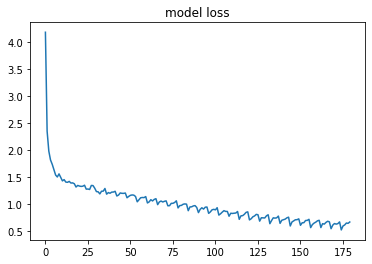

In [ ]:
# LSTM
num_epochs = 30

model_LSTM = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers,  drop_prob = drop_prob, rnn_cell = "LSTM").to(device)
losses_LSTM = train(train_loader, model_LSTM, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses_LSTM)
plt.title('model loss')
plt.show()

Using GRU
{'epoch': 0, 'batch': 0, 'loss': 4.183600425720215}
{'epoch': 0, 'batch': 30, 'loss': 2.2396857738494873}
{'epoch': 0, 'batch': 60, 'loss': 1.9503092765808105}
{'epoch': 0, 'batch': 90, 'loss': 1.8429914712905884}
{'epoch': 0, 'batch': 120, 'loss': 1.7296898365020752}
{'epoch': 0, 'batch': 150, 'loss': 1.6933647394180298}
{'epoch': 1, 'batch': 0, 'loss': 1.5750489234924316}
{'epoch': 1, 'batch': 30, 'loss': 1.543617606163025}
{'epoch': 1, 'batch': 60, 'loss': 1.4817004203796387}
{'epoch': 1, 'batch': 90, 'loss': 1.4729052782058716}
{'epoch': 1, 'batch': 120, 'loss': 1.4491580724716187}
{'epoch': 1, 'batch': 150, 'loss': 1.4470006227493286}
{'epoch': 2, 'batch': 0, 'loss': 1.410285472869873}
{'epoch': 2, 'batch': 30, 'loss': 1.410109519958496}
{'epoch': 2, 'batch': 60, 'loss': 1.3942583799362183}
{'epoch': 2, 'batch': 90, 'loss': 1.3754061460494995}
{'epoch': 2, 'batch': 120, 'loss': 1.4445884227752686}
{'epoch': 2, 'batch': 150, 'loss': 1.4282761812210083}
{'epoch': 3, 'batch

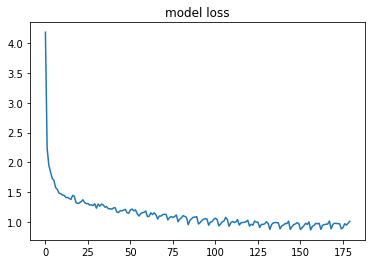

In [ ]:
# GRU
num_epochs = 30
model_GRU = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob, rnn_cell = "GRU").to(device)
losses_GRU = train(train_loader, model_GRU, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses_GRU)
plt.title('model loss')
plt.show()

Using default Simple RNN cells
{'epoch': 0, 'batch': 0, 'loss': 4.175312519073486}
{'epoch': 0, 'batch': 30, 'loss': 2.2570111751556396}
{'epoch': 0, 'batch': 60, 'loss': 2.060905694961548}
{'epoch': 0, 'batch': 90, 'loss': 1.9201915264129639}
{'epoch': 0, 'batch': 120, 'loss': 1.7992290258407593}
{'epoch': 0, 'batch': 150, 'loss': 1.7862389087677002}
{'epoch': 1, 'batch': 0, 'loss': 1.724524974822998}
{'epoch': 1, 'batch': 30, 'loss': 1.6860969066619873}
{'epoch': 1, 'batch': 60, 'loss': 1.6243486404418945}
{'epoch': 1, 'batch': 90, 'loss': 1.6099766492843628}
{'epoch': 1, 'batch': 120, 'loss': 1.5870447158813477}
{'epoch': 1, 'batch': 150, 'loss': 1.5890218019485474}
{'epoch': 2, 'batch': 0, 'loss': 1.5445513725280762}
{'epoch': 2, 'batch': 30, 'loss': 1.513710618019104}
{'epoch': 2, 'batch': 60, 'loss': 1.4773908853530884}
{'epoch': 2, 'batch': 90, 'loss': 1.4937766790390015}
{'epoch': 2, 'batch': 120, 'loss': 1.5468194484710693}
{'epoch': 2, 'batch': 150, 'loss': 1.5241934061050415

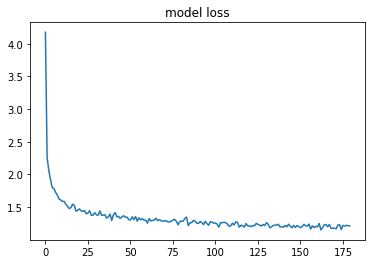

In [ ]:
# RNN
num_epochs = 30
model_RNN = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob, rnn_cell = "RNN").to(device)
losses_RNN = train(train_loader, model_RNN, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses_RNN)
plt.title('model loss')
plt.show()

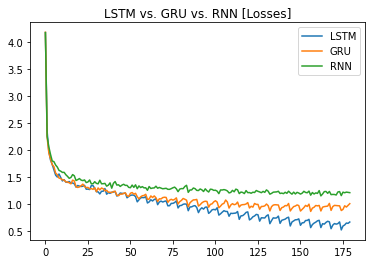

In [ ]:
plt.plot(losses_LSTM, label = "LSTM")
plt.plot(losses_GRU, label = "GRU")
plt.plot(losses_RNN, label = "RNN")
plt.legend()
plt.title('LSTM vs. GRU vs. RNN [Losses]')
plt.show()

B) Train your best model from previous exercise on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text. What differences do you appreciate? Why are they different?

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [ ]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.
Length of text: 807276 characters


In [ ]:
# YOUR CODE HERE
class NLTKDataset():
    def __init__(self, sequence_length,):
        self.sequence_length = sequence_length
        self.chars = self.load_chars()
        self.uniq_chars = self.get_uniq_chars()
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        self.chars_indexes = [self.char_to_index[w] for w in self.chars]

        self.x, self.y = self.get_data()

    def load_chars(self):
        text = inaugural.raw()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indexes)-self.sequence_length,self.sequence_length):
            x.append(np.array(self.chars_indexes[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indexes[index+1:index+self.sequence_length+1]))
        
        return  np.array(x), np.array(y)

In [ ]:
sequence_length = 100
nltk_data = NLTKDataset(sequence_length)

print(f'We have {nltk_data.x.shape[0]} input sequence samples of length {nltk_data.x.shape[1]} \
and {nltk_data.y.shape[0]} label sequences of length {nltk_data.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_data_nltk = TensorDataset(torch.from_numpy(nltk_data.x), torch.from_numpy(nltk_data.y))
train_loader_nltk = DataLoader(train_data_nltk, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 807276 characters
Unique characters (vocabulary size): 85
We have 8072 input sequence samples of length 100 and 8072 label sequences of length 100


In [ ]:
input_dim = len(nltk_data.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(nltk_data.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_LSTM = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob, rnn_cell = "LSTM").to(device)

print(model_LSTM)

Using LSTM
Model(
  (embedding): Embedding(85, 300)
  (rnn): LSTM(300, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=85, bias=True)
)


{'epoch': 0, 'batch': 0, 'loss': 4.440564155578613}
{'epoch': 0, 'batch': 30, 'loss': 2.338052272796631}
{'epoch': 0, 'batch': 60, 'loss': 1.9107533693313599}
{'epoch': 0, 'batch': 90, 'loss': 1.6841212511062622}
{'epoch': 0, 'batch': 120, 'loss': 1.5542510747909546}
{'epoch': 1, 'batch': 0, 'loss': 1.5257368087768555}
{'epoch': 1, 'batch': 30, 'loss': 1.4630422592163086}
{'epoch': 1, 'batch': 60, 'loss': 1.4170050621032715}
{'epoch': 1, 'batch': 90, 'loss': 1.3253544569015503}
{'epoch': 1, 'batch': 120, 'loss': 1.2946264743804932}
{'epoch': 2, 'batch': 0, 'loss': 1.278019905090332}
{'epoch': 2, 'batch': 30, 'loss': 1.2754080295562744}
{'epoch': 2, 'batch': 60, 'loss': 1.2447470426559448}
{'epoch': 2, 'batch': 90, 'loss': 1.220105767250061}
{'epoch': 2, 'batch': 120, 'loss': 1.2101858854293823}
{'epoch': 3, 'batch': 0, 'loss': 1.1835800409317017}
{'epoch': 3, 'batch': 30, 'loss': 1.2242404222488403}
{'epoch': 3, 'batch': 60, 'loss': 1.1706819534301758}
{'epoch': 3, 'batch': 90, 'loss':

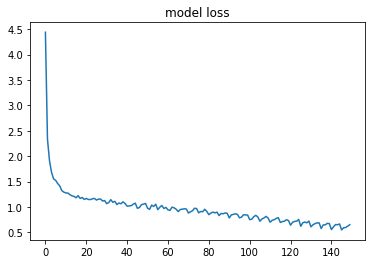

In [ ]:
num_epochs = 30
losses_LSTM = train(train_loader_nltk, model_LSTM, batch_size, sequence_length, num_epochs)

# Visualize the loss evolution during training
plt.plot(losses_LSTM)
plt.title('model loss')
plt.show()

In [ ]:
def predict_LSTM(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state, c = model.init_hidden(1)


    # we start by feeding all the input characters to our model
    x = torch.tensor([[dataset.char_to_index[char] for char in chars[0:]]])
    x = x.to(device)

    for i in range(0, next_chars):
        
        y_pred, state, c = model(x, state, c)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

In [ ]:
predicted_LSTM = predict_LSTM(nltk_data, model_LSTM,'ROMEO:')
print("\nLSTM\n")
print(''.join(predicted_LSTM))


LSTM

ROMEO:
The safeture of administration, if the other departments, you have come slowly at par by the Government of the people, I serind it because all these amidations and regard from it when justice and their responsibilities.

Ad for the fortunes of year.

I would respond to the executive branch of the Government and the laws of the Constitution and laws because they believes in necessity, regarding them and cherish a sacred designed that it will be to stand here and the cornger States have not been escaped its destination, but of all our proper powers long ajorities so gloriously pronounce, and fair dealing and opportunity. In no nation has liberated, to strengthen a treaty of general rule, that the tax belief over the last four years which would gave a true men of government, but ethey will enterpresent car the stars bow justice to the States or to assist in the attempt to live to express my appreciation to the Presidency I will act by time governing their improvement and rev

El texto que obtenemos tiene una estructura diferente al output del ejercicio anterior, se muestran oraciones largas, en su mayoría compuestas y en formato de discurso a diferencia del anterior formato poético de Shakespeare con saltos de línea cada pocas palabras. Los temas que aborda son de contexto político como la guerra, prosperidad, población, etc. y en la salida del modelo entrenado anteriormente se habla sobre temas de amor y reinos. El punto común que les une es la coherencia gramatical y la formación de palabras existentes (o no) en el vocabulario inglés, ya que tiene algunas carencias en la hora de crear texto real. Es decir, sabríamos distinguir entre este texto y uno escrito por un humano. En mi opinión el modelo es eficaz pero sencillo, pues falta complejidad en su estructura o más epochs de training para lograr un texto realmente verosímil. Cabe decir, que esta aproximación es muy realista para la profundidad y estructura básica del modelo de aprendizaje. 